### Lead Scoring Case Study 

- Supervised Learning Algorithm - Logistic Regression [ Classification ]
- Programming Language - Python
- Developed by UV, VK, VY


#### Data Preprocessing

In [736]:
# import all libraries numpy, pandas, matplotlib, seaborn. 
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline

# Set custom display properties in pandas
pd.set_option("display.max_rows", 900)
pd.set_option("display.max_columns", 900) 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [737]:
import statsmodels.api as sm 
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, recall_score,precision_score, roc_auc_score, confusion_matrix, f1_score, roc_curve, precision_recall_curve

In [738]:
# To distinguish numerical columns either as categorical/discrete or non categorical and return as dict
def classify_feature_dtype(df,cols):
    d_categories = {'int_cat': [], "float_ts":[] }
    for col in cols:
        if (len(df[col].unique()) < 20):
            d_categories['int_cat'].append(col)
        else:
            d_categories['float_ts'].append(col)
    return d_categories

# Print all statistical information for a given set of columns
def show_stats(df, cols):
    for col in list(cols):
        print("Total Nulls: {0},\nMode: {1}".format(df[col].isna().sum(), df[col].mode()[0]))
        if len(df[col].unique()) < 50:
            print("\nUnique: {0}\n".format(df[col].unique()))
        if (df[col].dtype == int) or (df[col].dtype == float):
            print("Median   : {0}, \nVariance: {1}, \n\nDescribe: {2} \n".format(df[col].median(), df[col].var(), df[col].describe()))
        print("ValueCounts: {0} \n\n\n".format((df[col].value_counts(normalize=True) * 100).head(5)))
        print("------------------------------------------------------------------")

# Return the percentage of null values in each columns in a dataframe
def check_cols_null_pct(df):
    df_non_na = df.count() / len(df)  # Ratio of non null values
    df_na_pct = (1 - df_non_na) * 100 # Find the Percentage of null values
    return df_na_pct.sort_values(ascending=False) # Sort the resulting values in descending order

# Generates charts based on the data type of the cols, as part of the univariate analysis 
# it takes dataframe, columns, train data 0,1, and feature type as args.
def univariate_plots(df, cols, target=None, ftype=None, l_dict = None):
    for col in cols:
        #generate plots and graphs for category type. (generates piechart, countplot, boxplot / if training data is provided it generates bar chart instead)
        if ftype == "categorical":
            fig, axs = plt.subplots(1, 3, figsize=(20, 6))
                        
            col_idx = 0
            axs[col_idx].pie(x=df[col].value_counts().head(15), labels=df[col].value_counts().head(15).index.str[:15], autopct="%1.1f%%", 
                    radius=1, textprops={"fontsize": 10, "color": "Black"}, startangle=90, rotatelabels=False)
            axs[col_idx].set_title("PieChart of {0}".format(col), y=1); plt.xticks(rotation=45); plt.ylabel("Percentage")
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1
            sns.countplot(data=df, y=col, order=df[col].value_counts().index, palette="viridis",  ax=axs[col_idx])
            if (l_dict is not None) and (l_dict.get(col) is not None):
                axs[col_idx].legend([ f'{k} - {v}' for k,v in l_dict[col].items()])
            axs[col_idx].set_title("Countplot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col); plt.ylabel("Count")
            fig.subplots_adjust(wspace=0.5, hspace=0.3)

            col_idx += 1
            ax = sns.barplot(data=df, x=df[col].str[:15], y=target, palette="viridis",  ax=axs[col_idx], errwidth=0)
            for i in ax.containers:
                ax.bar_label(i,)
            axs[col_idx].set_title('Barplot against target'); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)

            plt.suptitle("Univariate analysis of {0}".format(col), fontsize=12, y=0.95)
            plt.tight_layout()
            plt.subplots_adjust(top=0.85)
            plt.show()
            plt.clf()

        #generate plots and graphs for numerical types. (generates boxplot, histplot, kdeplot, scatterplot)
        elif ftype == "non_categorical":        
            fig, axs = plt.subplots(1, 4, figsize=(20, 6))
            
            col_idx = 0
            
            sns.boxplot(data=df, y=col, palette="viridis", flierprops=dict( marker="o", markersize=6, markerfacecolor="red", markeredgecolor="black"),
                        medianprops=dict(linestyle="-", linewidth=3, color="#FF9900"), whiskerprops=dict(linestyle="-", linewidth=2, color="black"),
                        capprops=dict(linestyle="-", linewidth=2, color="black"), ax=axs[col_idx])
            axs[col_idx].set_title("Boxplot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1

            axs[col_idx].hist(data=df, x=col, label=col)
            axs[col_idx].set_title("Histogram of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1

            sns.kdeplot(df[col], shade=True, ax=axs[col_idx])
            axs[col_idx].set_title("KDE plot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1

            sns.scatterplot(df[col], ax=axs[col_idx])
            axs[col_idx].set_title("Scatterplot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)

            plt.suptitle("Univariate analysis of {0}".format(col), fontsize=12, y=0.95)
            plt.tight_layout()
            plt.subplots_adjust(top=0.85)
            plt.show()
            plt.clf()

# Perform Outlier analysis on the given dataframe.
# Find Lower threshold, Upper threshold and IQR values. 
# Return the Result as a dataframe. 
# find_outlier = True argument: restricts the output df to outlier columns. whereas find_outlier = False: returns results for all columns
def get_extremeval_threshld(df, find_outlier=False):
    outlier_df = pd.DataFrame(columns=[i for i in df.columns if find_outlier == True], data=None)
    
    for col in df.columns:
        thirdq, firstq = df[col].quantile(0.75), df[col].quantile(0.25)
        iqr = 1.5 * (thirdq - firstq)
        extvalhigh, extvallow = iqr + thirdq, firstq - iqr
        
        if find_outlier == True:
            dfout = df.loc[(df[col] > extvalhigh) | (df[col] < extvallow)]
            dfout = dfout.assign(name=col, thresh_low=extvallow, thresh_high=extvalhigh)
        else:
            dfout = pd.DataFrame([[col, extvallow, extvalhigh]], columns=['name', 'thresh_low', 'thresh_high'])
            
        outlier_df = pd.concat([outlier_df, dfout])
    # outlier_df = outlier_df.reset_index(drop=True)
    outlier_df = outlier_df.set_index('name',drop=True)
    return outlier_df

In [739]:
lead_score_df = pd.read_csv('Leads.csv')
lead_score_df.head(1)

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.000,0,0.000,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.000,15.000,No,No,Modified


In [740]:
#duplicates row validation by id cols
print(f"{lead_score_df.index.is_unique}, {lead_score_df.columns.is_unique}, {lead_score_df['Prospect ID'].is_unique}, {lead_score_df['Lead Number'].is_unique}")

True, True, True, True


In [741]:
# drop unnecessary columns
lead_score_df = lead_score_df.drop(columns=['Prospect ID', 'I agree to pay the amount through cheque', 'Last Notable Activity'])

In [742]:
# rename columns that are too long
lead_score_df = lead_score_df.rename(columns={'Total Time Spent on Website':'ttime_on_site', 'Page Views Per Visit':'pg_view_pv', 'How did you hear about X Education':'info_abt_X_Edu', 'What is your current occupation':'curr_occupation',
    'What matters most to you in choosing a course':'reason_behind_course', 'Receive More Updates About Our Courses':'more_course_updates', 'Update me on Supply Chain Content':'supply_chain_info', 'Get updates on DM Content':'get_dm',
    'Asymmetrique Activity Index':'asym_activ_idx', 'Asymmetrique Profile Index':'asym_prof_idx', 'Asymmetrique Activity Score':'asym_activ_score', 'Asymmetrique Profile Score':'asym_prof_score',
    'A free copy of Mastering The Interview':'avail_free_copy'})

In [743]:
# replace unnecessary space in columns with underscore and covert it to lower case
lead_score_df.columns = lead_score_df.columns.str.replace(pat=' ',repl='_', regex=True)
lead_score_df.columns = lead_score_df.columns.str.lower()

In [744]:
lead_score_df.head(1)
lead_score_df.dtypes
print(f'{lead_score_df.shape}, {lead_score_df.size}')

,lead_number,lead_origin,lead_source,do_not_email,do_not_call,converted,totalvisits,ttime_on_site,pg_view_pv,last_activity,country,specialization,info_abt_x_edu,curr_occupation,reason_behind_course,search,magazine,newspaper_article,x_education_forums,newspaper,digital_advertisement,through_recommendations,more_course_updates,tags,lead_quality,supply_chain_info,get_dm,lead_profile,city,asym_activ_idx,asym_prof_idx,asym_activ_score,asym_prof_score,avail_free_copy
0,660737,API,Olark Chat,No,No,0,0.000,0,0.000,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.000,15.000,No


lead_number                  int64
lead_origin                 object
lead_source                 object
do_not_email                object
do_not_call                 object
converted                    int64
totalvisits                float64
ttime_on_site                int64
pg_view_pv                 float64
last_activity               object
country                     object
specialization              object
info_abt_x_edu              object
curr_occupation             object
reason_behind_course        object
search                      object
magazine                    object
newspaper_article           object
x_education_forums          object
newspaper                   object
digital_advertisement       object
through_recommendations     object
more_course_updates         object
tags                        object
lead_quality                object
supply_chain_info           object
get_dm                      object
lead_profile                object
city                

(9240, 34), 314160


In [745]:
# check null val percentage
check_cols_null_pct(lead_score_df)

lead_quality              51.591
asym_prof_score           45.649
asym_activ_score          45.649
asym_prof_idx             45.649
asym_activ_idx            45.649
tags                      36.288
lead_profile              29.318
reason_behind_course      29.318
curr_occupation           29.113
country                   26.634
info_abt_x_edu            23.885
specialization            15.563
city                      15.368
pg_view_pv                 1.483
totalvisits                1.483
last_activity              1.115
lead_source                0.390
more_course_updates        0.000
get_dm                     0.000
supply_chain_info          0.000
lead_number                0.000
newspaper_article          0.000
through_recommendations    0.000
digital_advertisement      0.000
newspaper                  0.000
x_education_forums         0.000
lead_origin                0.000
magazine                   0.000
search                     0.000
ttime_on_site              0.000
converted 

In [746]:
# replace select string with nan
lead_score_df = lead_score_df.replace(to_replace=['select','Select'], value=np.nan)

# validate select str is replaced
[i for i in lead_score_df.columns if 'select' in (lead_score_df[i].astype(str).str.lower()).str.findall('select').value_counts().index.map(''.join).to_list()]

[]

In [747]:
# check constant features that has only one values 
from fast_ml.utilities import display_all
from fast_ml.feature_selection import get_constant_features

constant_features = get_constant_features(lead_score_df)
constant_features.head(10)
"','".join(constant_features['Var'].to_list())

,Desc,Var,Value,Perc
0,Constant,magazine,No,100.000
1,Constant,more_course_updates,No,100.000
2,Constant,supply_chain_info,No,100.000
3,Constant,get_dm,No,100.000
4,Quasi Constant,x_education_forums,No,99.989
5,Quasi Constant,newspaper,No,99.989
6,Quasi Constant,do_not_call,No,99.978
7,Quasi Constant,newspaper_article,No,99.978
8,Quasi Constant,digital_advertisement,No,99.957
9,Quasi Constant,through_recommendations,No,99.924


"magazine','more_course_updates','supply_chain_info','get_dm','x_education_forums','newspaper','do_not_call','newspaper_article','digital_advertisement','through_recommendations','search"

In [748]:
# drop all the constant_features
lead_score_df = lead_score_df.drop(['magazine', 'more_course_updates', 'supply_chain_info', 'get_dm', 'x_education_forums', 
                                    'newspaper', 'do_not_call', 'newspaper_article', 'digital_advertisement', 'through_recommendations', 'search'],axis=1)

In [749]:
# convert dtypes 
obj_cols = lead_score_df.select_dtypes(include=object).columns
lead_score_df[obj_cols] = lead_score_df[obj_cols].astype(dtype='category')

In [750]:
# check null val percentage
null_pct = check_cols_null_pct(lead_score_df)
null_pct
lead_score_df = lead_score_df.drop(null_pct[null_pct > 40].index, axis=1)

info_abt_x_edu         78.463
lead_profile           74.188
lead_quality           51.591
asym_prof_score        45.649
asym_activ_score       45.649
asym_prof_idx          45.649
asym_activ_idx         45.649
city                   39.708
specialization         36.580
tags                   36.288
reason_behind_course   29.318
curr_occupation        29.113
country                26.634
totalvisits             1.483
pg_view_pv              1.483
last_activity           1.115
lead_source             0.390
lead_number             0.000
lead_origin             0.000
ttime_on_site           0.000
converted               0.000
do_not_email            0.000
avail_free_copy         0.000
dtype: float64

In [751]:
null_pct = check_cols_null_pct(lead_score_df)
null_pct
na_cols = null_pct[null_pct > 0].index
na_cols

city                   39.708
specialization         36.580
tags                   36.288
reason_behind_course   29.318
curr_occupation        29.113
country                26.634
totalvisits             1.483
pg_view_pv              1.483
last_activity           1.115
lead_source             0.390
lead_number             0.000
lead_origin             0.000
do_not_email            0.000
converted               0.000
ttime_on_site           0.000
avail_free_copy         0.000
dtype: float64

Index(['city', 'specialization', 'tags', 'reason_behind_course',
       'curr_occupation', 'country', 'totalvisits', 'pg_view_pv',
       'last_activity', 'lead_source'],
      dtype='object')

In [752]:
lead_score_df.describe(include=np.number)
lead_score_df.describe(exclude=np.number)

,lead_number,converted,totalvisits,ttime_on_site,pg_view_pv
count,9240.000,9240.000,9103.000,9240.000,9103.000
mean,617188.436,0.385,3.445,487.698,2.363
std,23405.996,0.487,4.855,548.021,2.161
min,579533.000,0.000,0.000,0.000,0.000
25%,596484.500,0.000,1.000,12.000,1.000
50%,615479.000,0.000,3.000,248.000,2.000
75%,637387.250,1.000,5.000,936.000,3.000
max,660737.000,1.000,251.000,2272.000,55.000


,lead_origin,lead_source,do_not_email,last_activity,country,specialization,curr_occupation,reason_behind_course,tags,city,avail_free_copy
count,9240,9204,9240,9137,6779,5860,6550,6531,5887,5571,9240
unique,5,21,2,17,38,18,6,3,26,6,2
top,Landing Page Submission,Google,No,Email Opened,India,Finance Management,Unemployed,Better Career Prospects,Will revert after reading the email,Mumbai,No
freq,4886,2868,8506,3437,6492,976,5600,6528,2072,3222,6352


In [753]:
# impute missing categorical values using mode, if a particular value in that column has higher frequency say > 50%
for i in lead_score_df.select_dtypes(include='category'):
    temp = lead_score_df[i].value_counts(normalize=True, ascending=False) * 100
    if temp.iloc[0] > 50:
        lead_score_df[i] = lead_score_df[i].fillna(temp.index[0])

In [754]:
null_pct = check_cols_null_pct(lead_score_df)
null_pct[null_pct > 0]

specialization   36.580
tags             36.288
totalvisits       1.483
pg_view_pv        1.483
last_activity     1.115
lead_source       0.390
dtype: float64

- specialization   36.580
- tags             36.288
- totalvisits       1.483
- pg_view_pv        1.483
- last_activity     1.115
- lead_source       0.390

####  ----------------------------------------------------------------------

#### Data Visualization

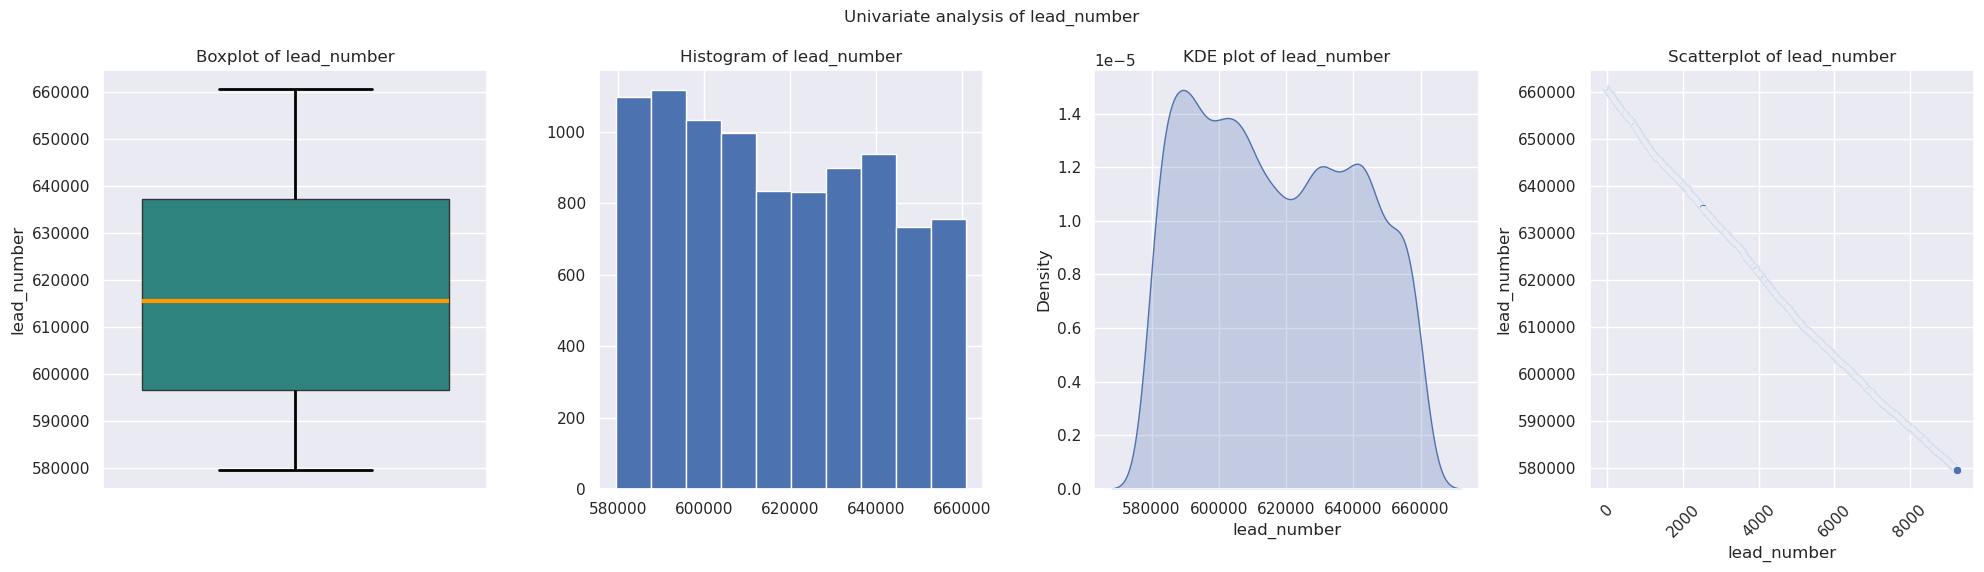

<Figure size 640x480 with 0 Axes>

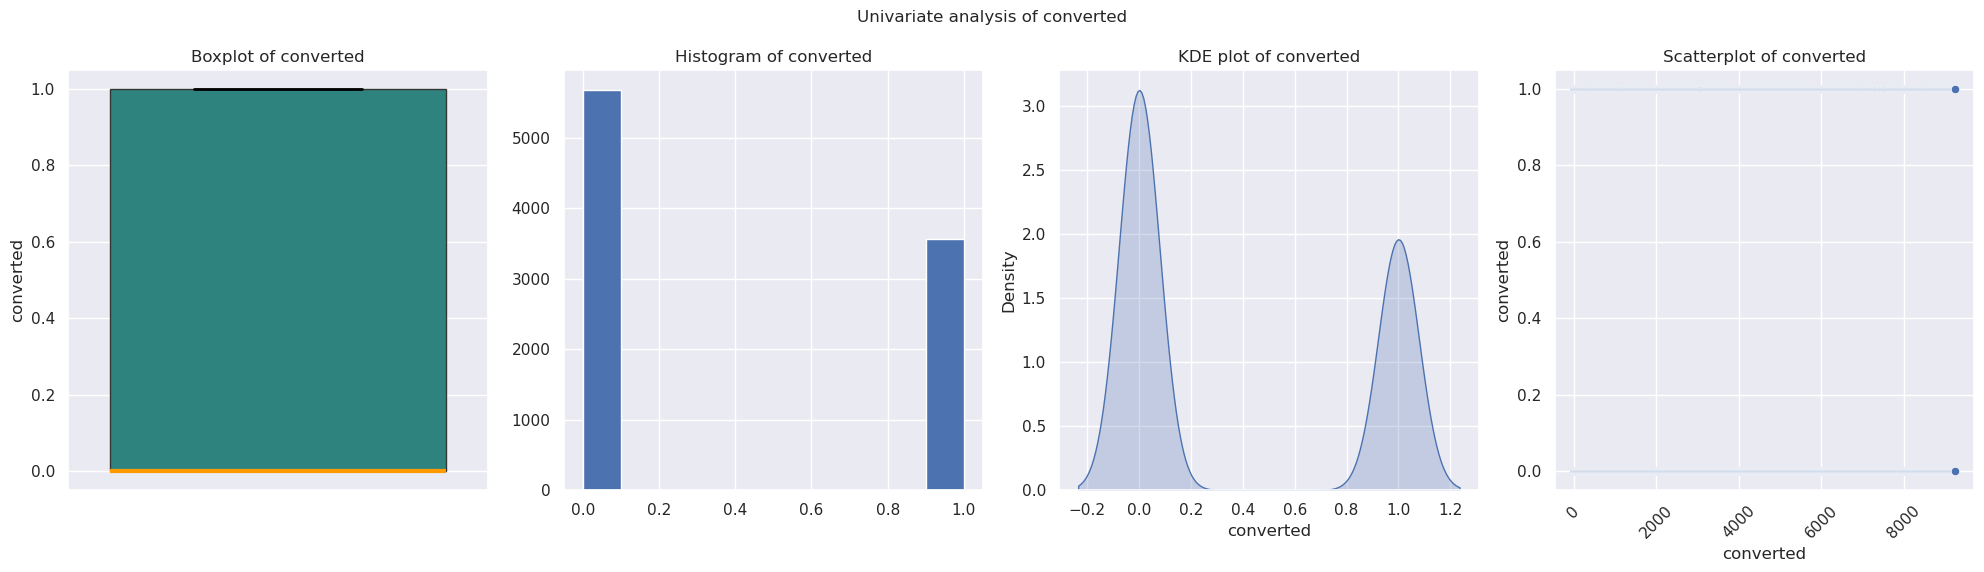

<Figure size 640x480 with 0 Axes>

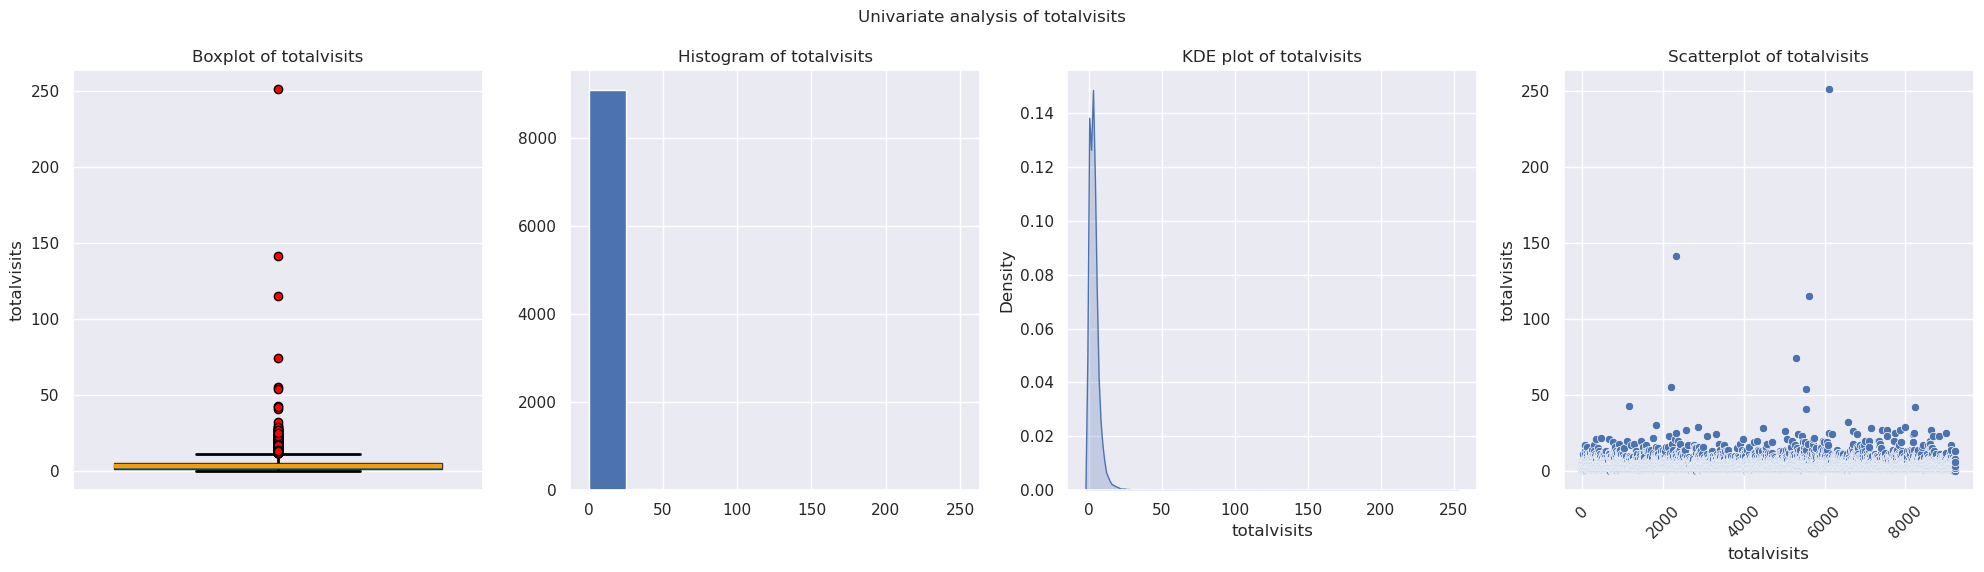

<Figure size 640x480 with 0 Axes>

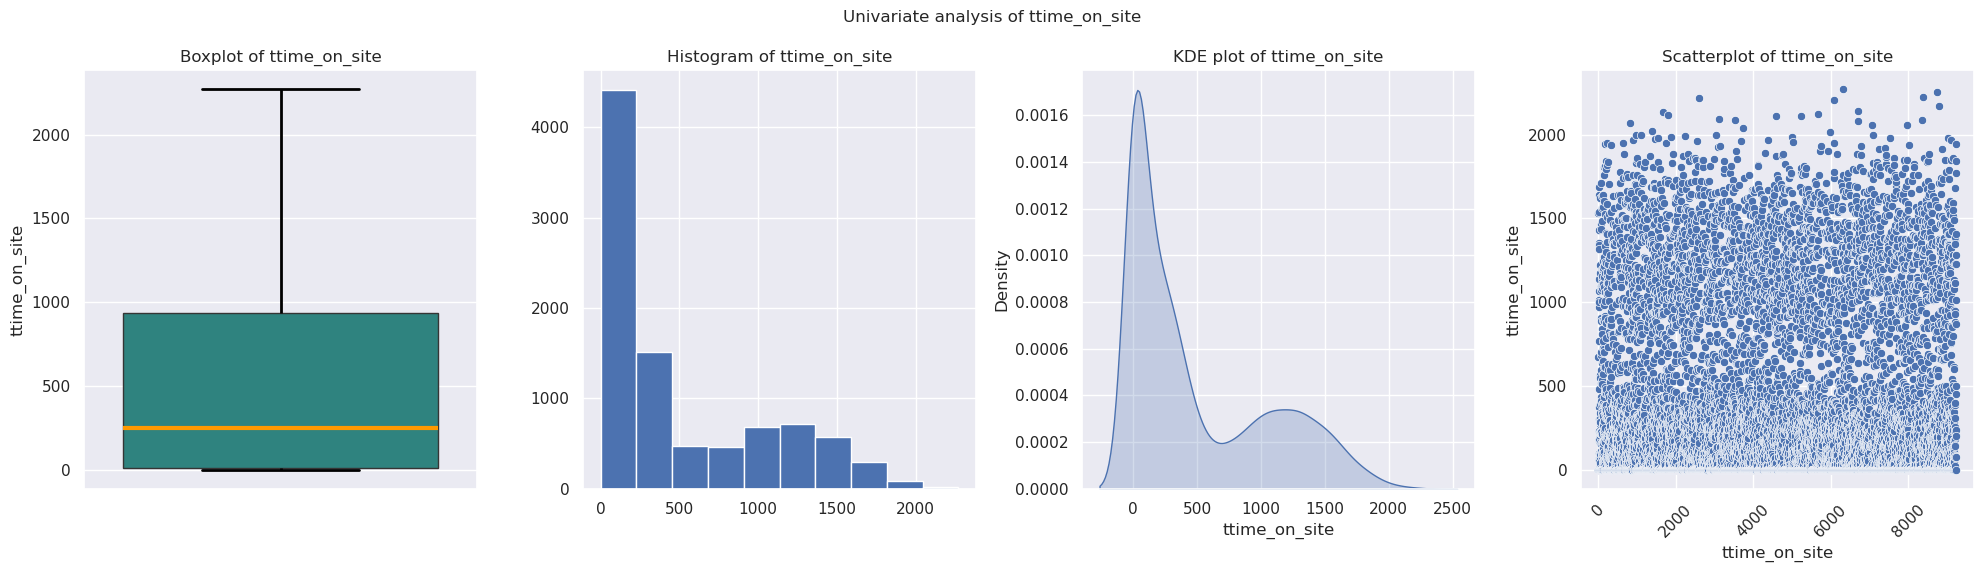

<Figure size 640x480 with 0 Axes>

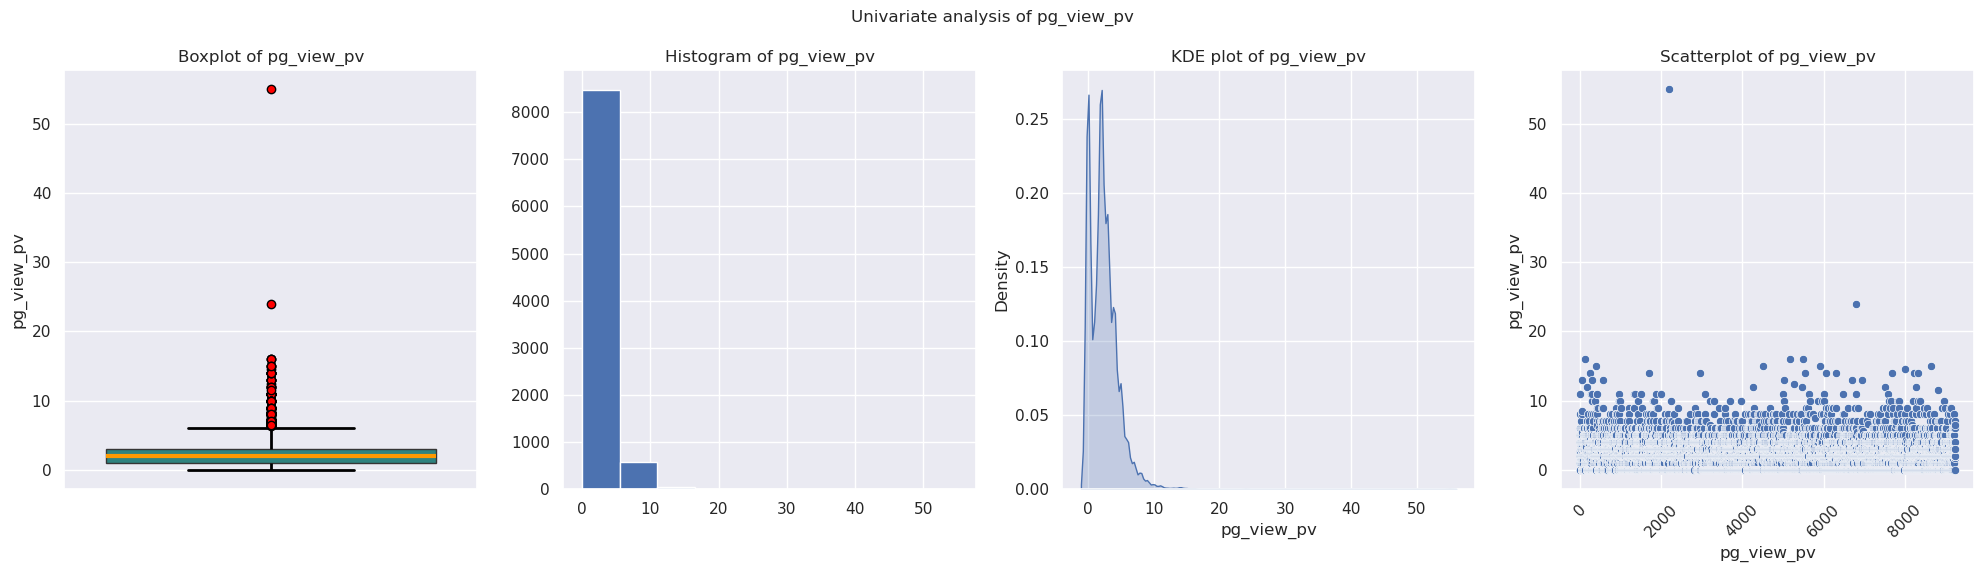

<Figure size 640x480 with 0 Axes>

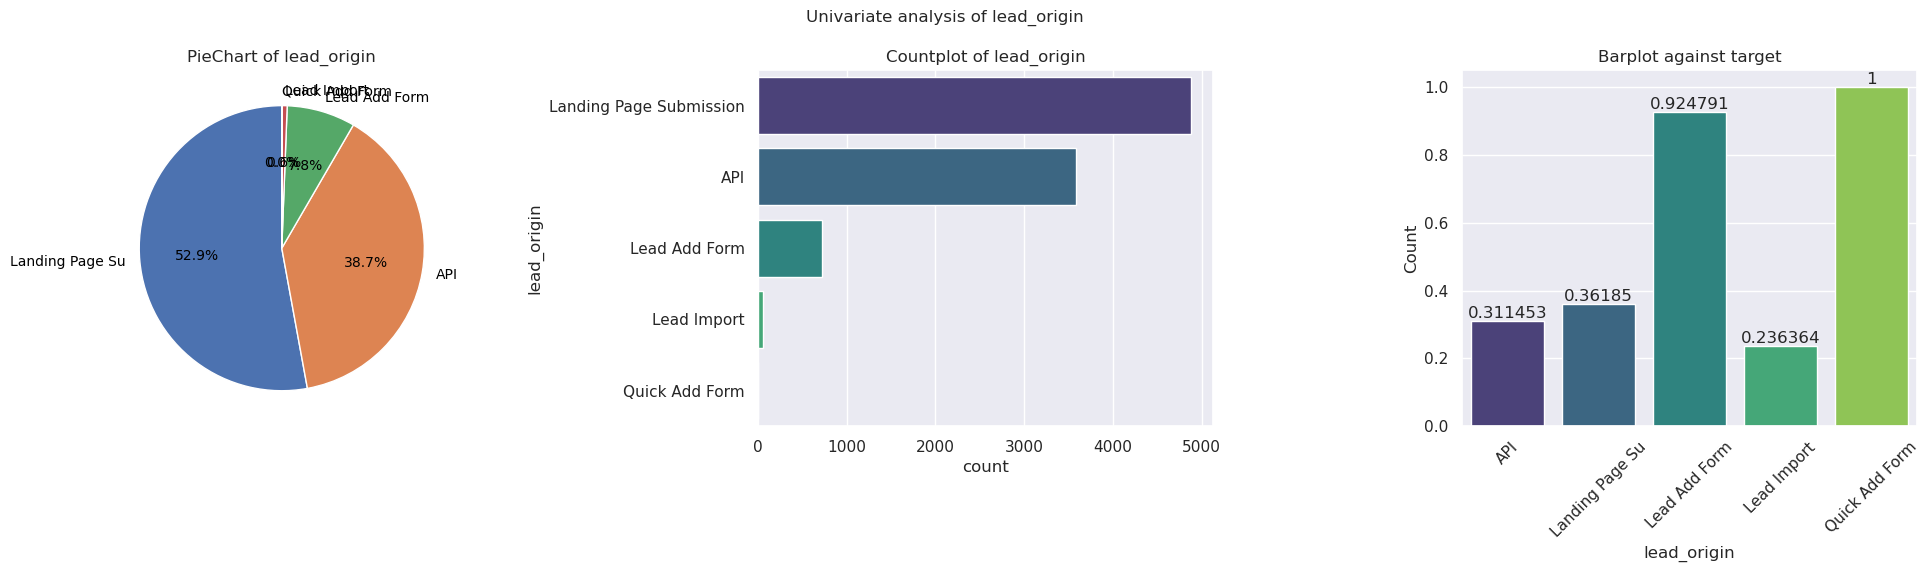

<Figure size 640x480 with 0 Axes>

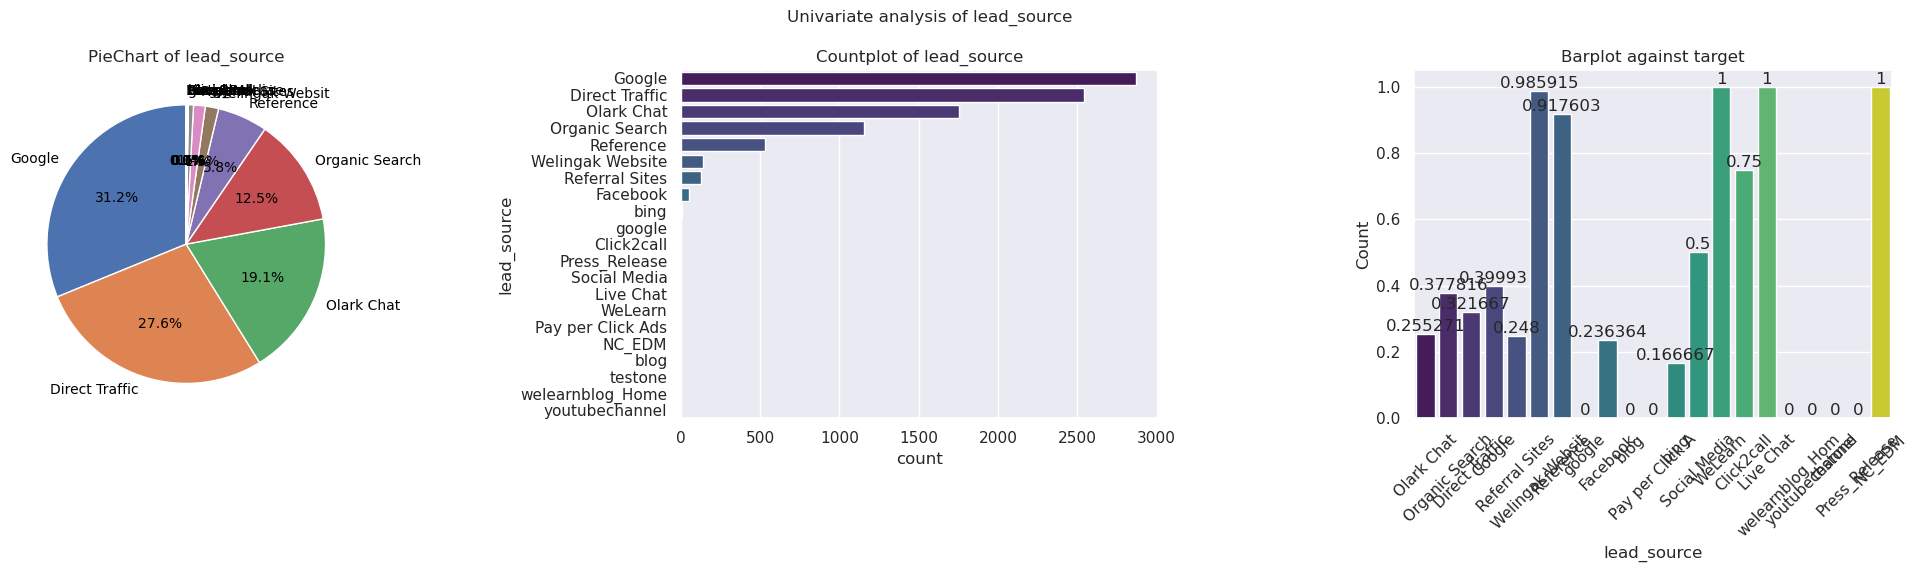

<Figure size 640x480 with 0 Axes>

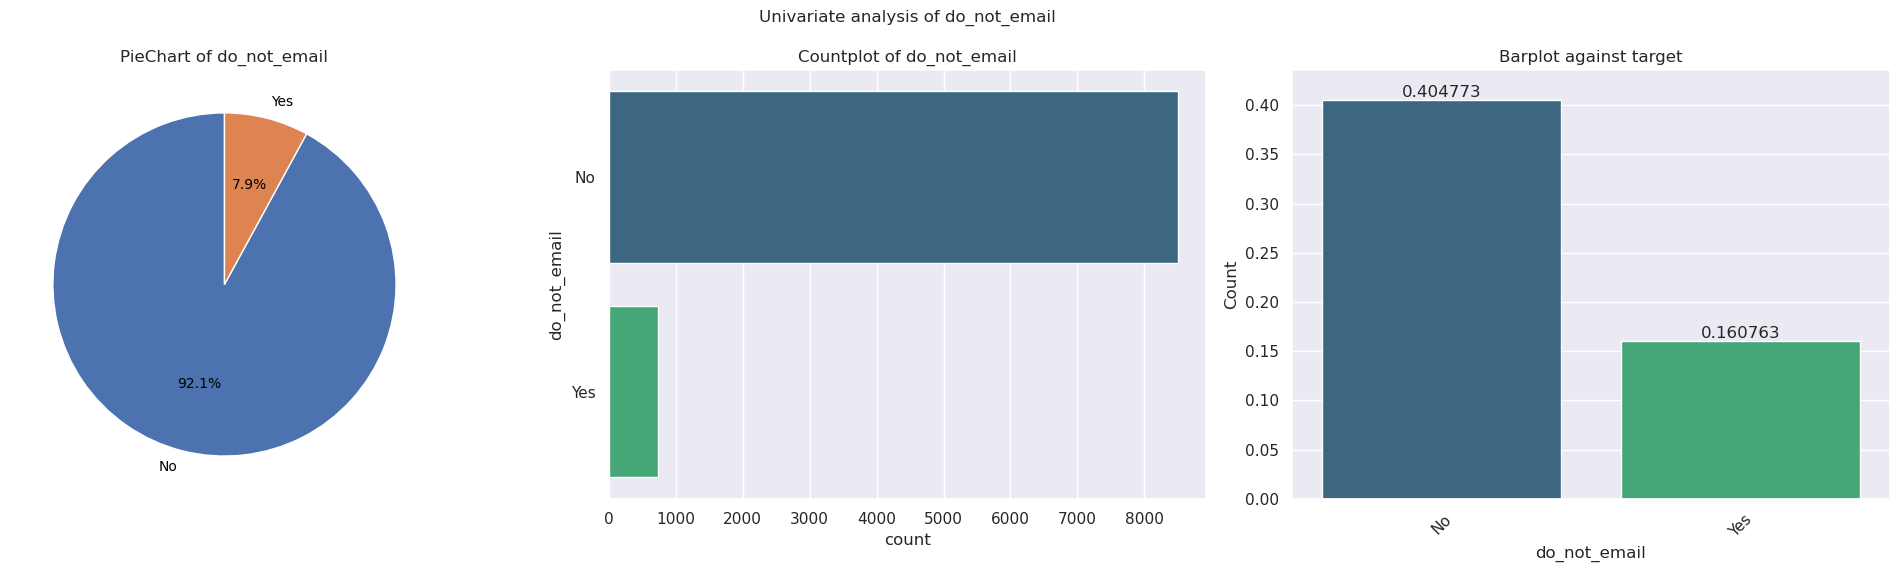

<Figure size 640x480 with 0 Axes>

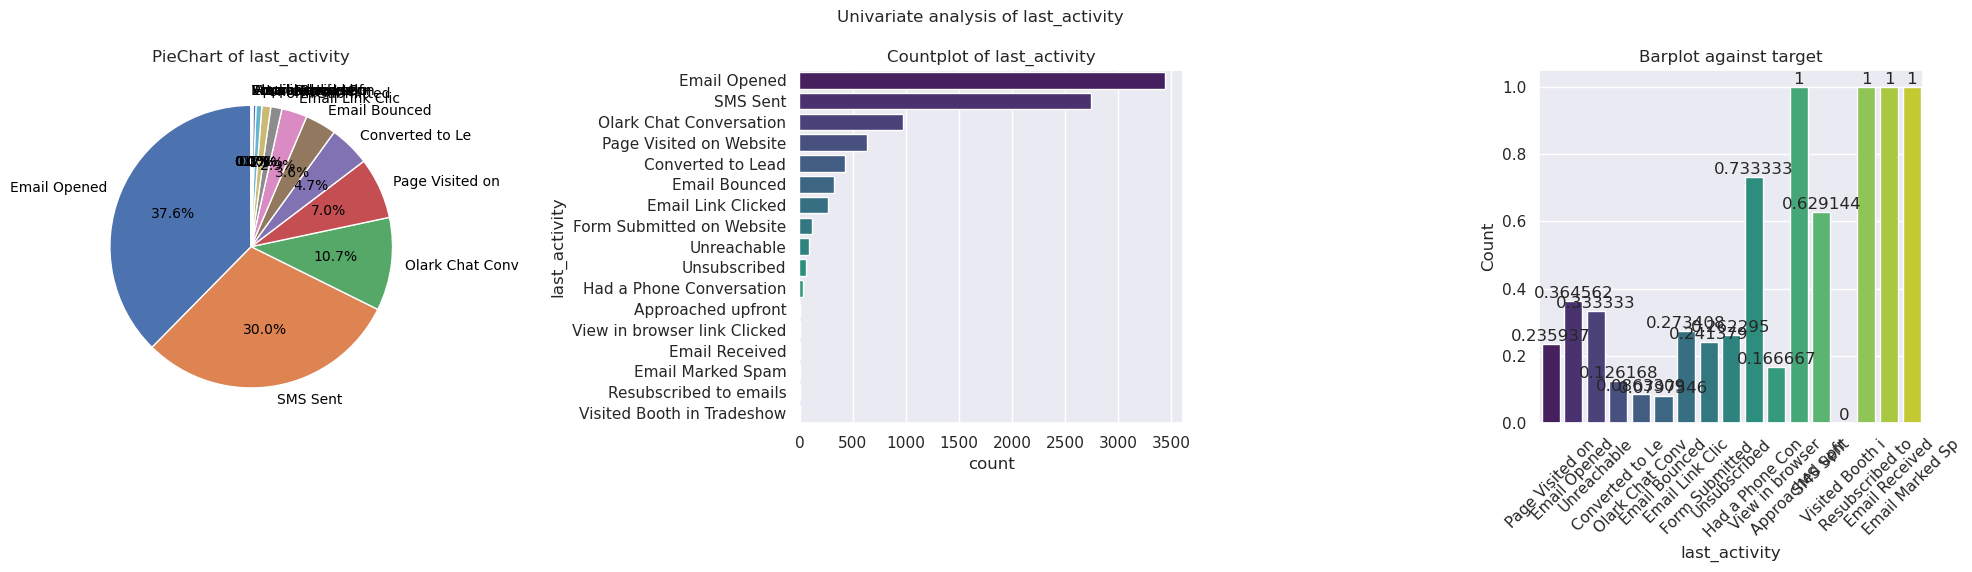

<Figure size 640x480 with 0 Axes>

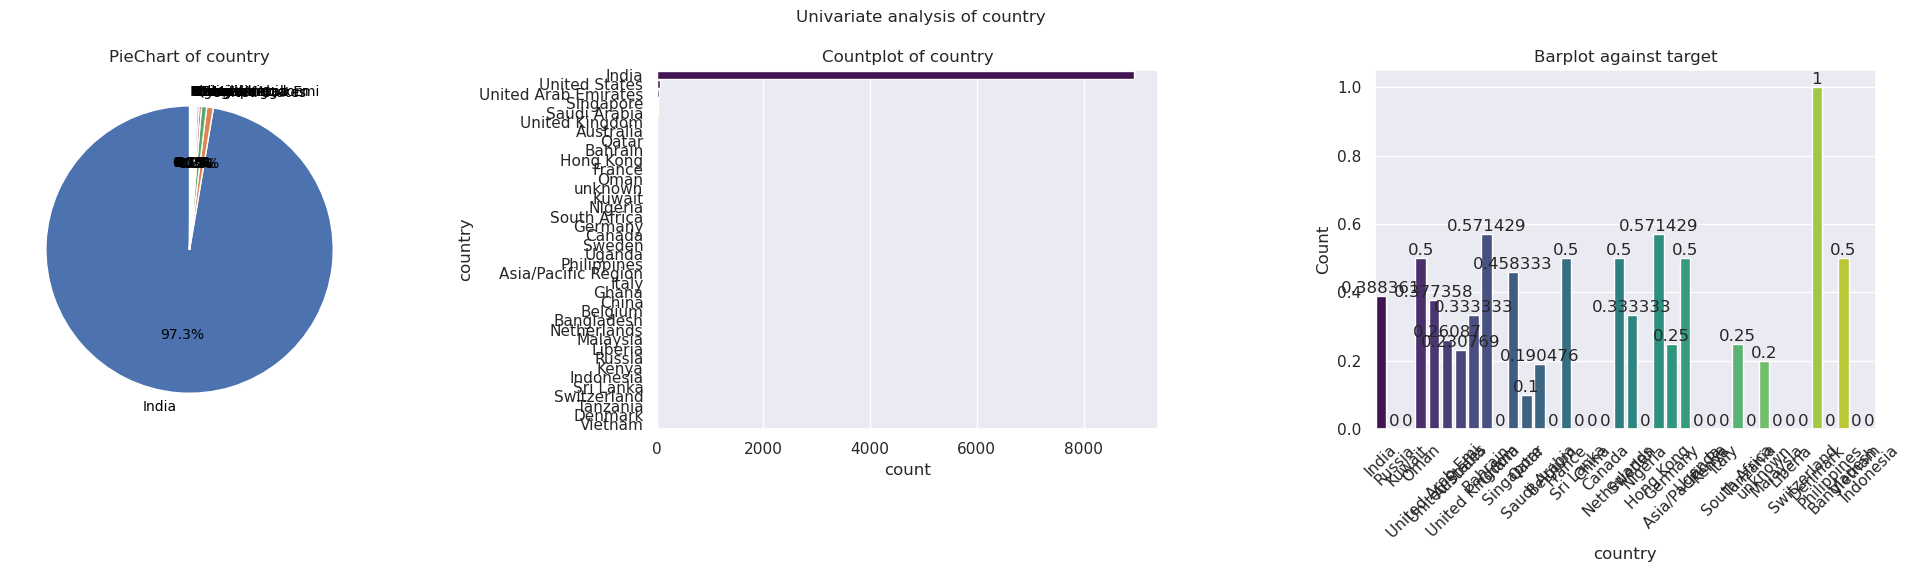

<Figure size 640x480 with 0 Axes>

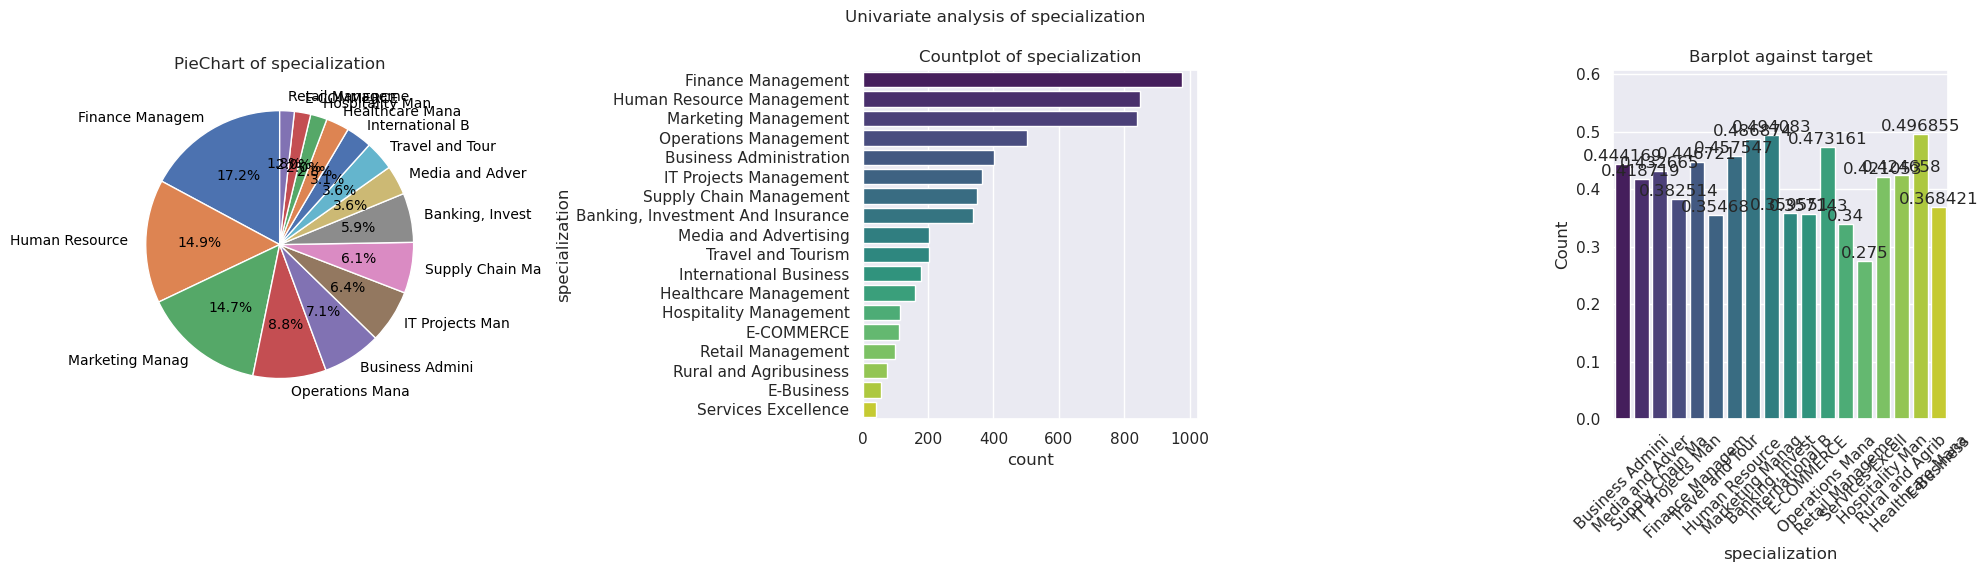

<Figure size 640x480 with 0 Axes>

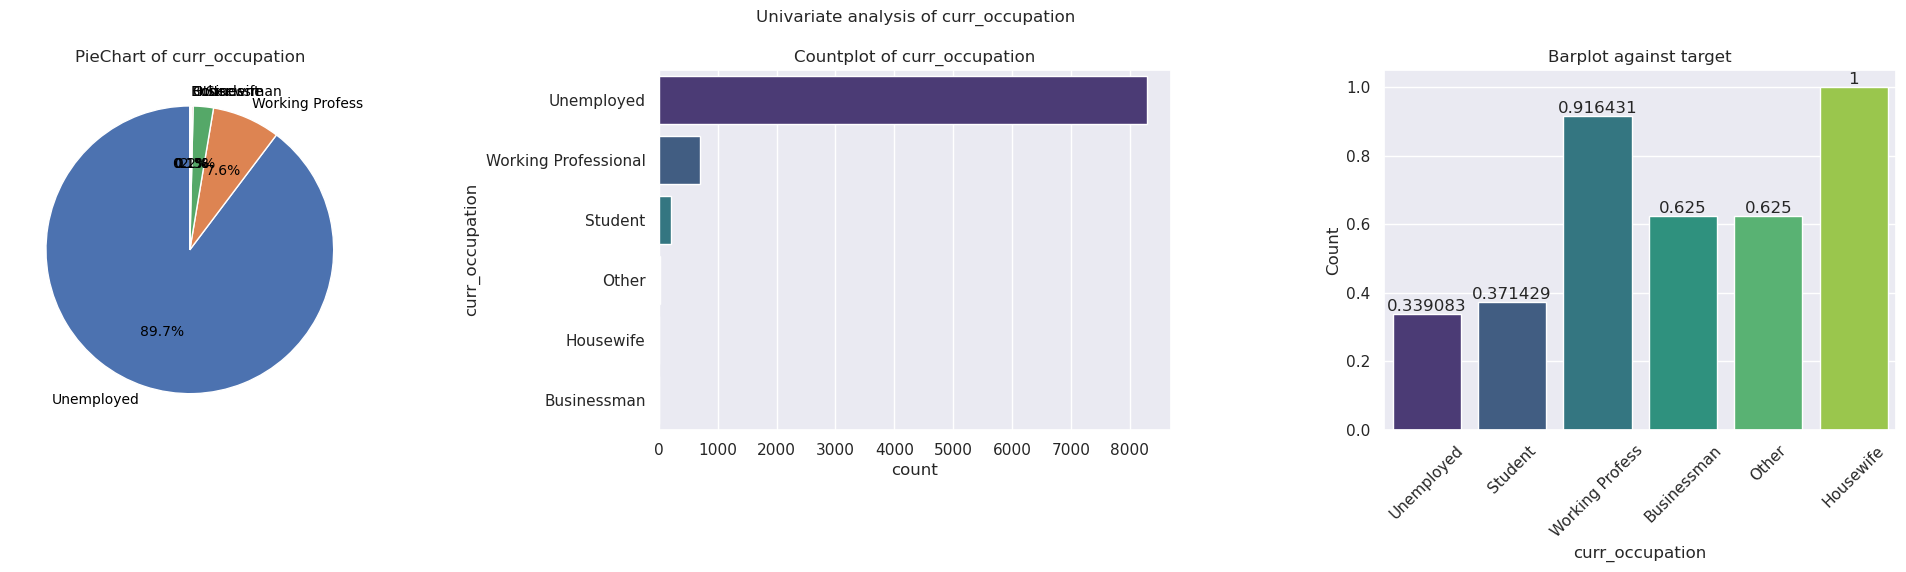

<Figure size 640x480 with 0 Axes>

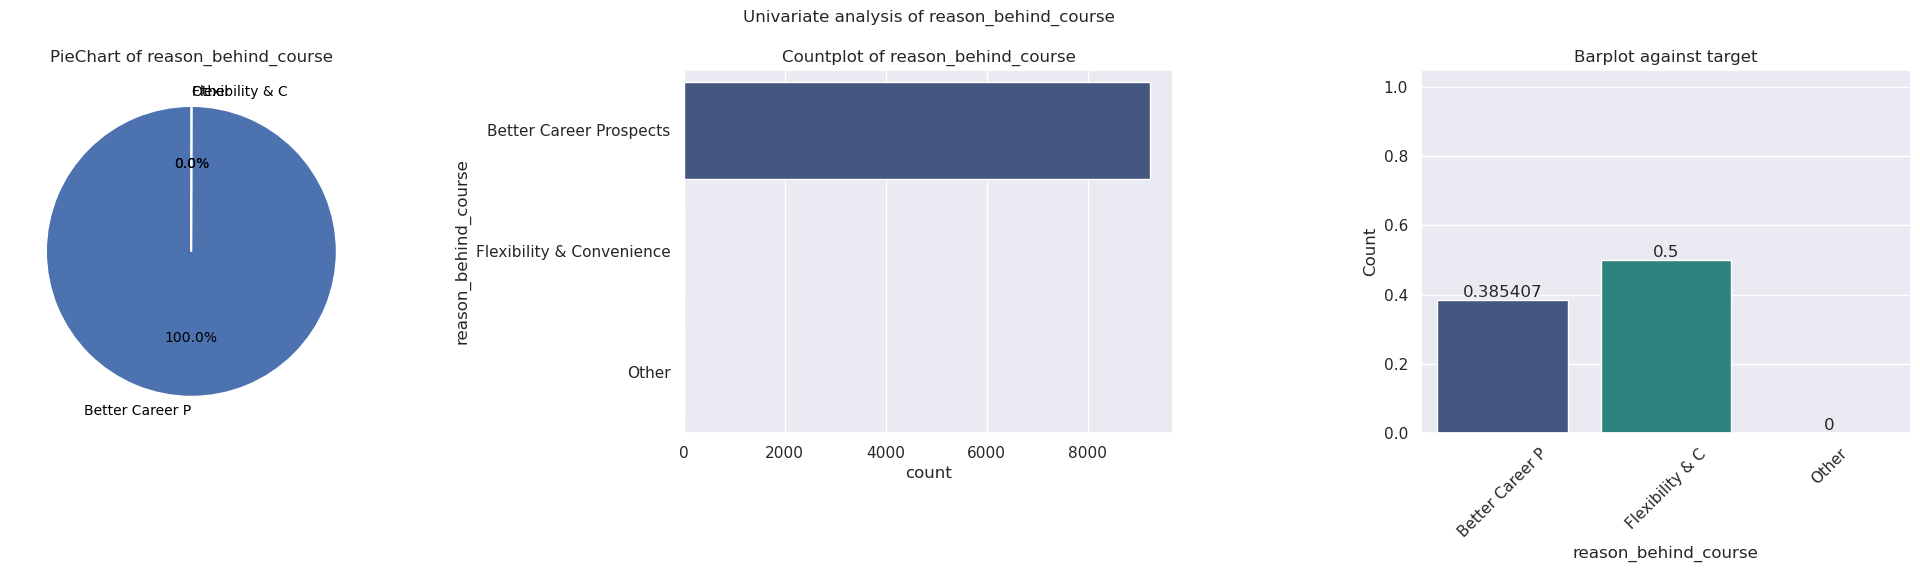

<Figure size 640x480 with 0 Axes>

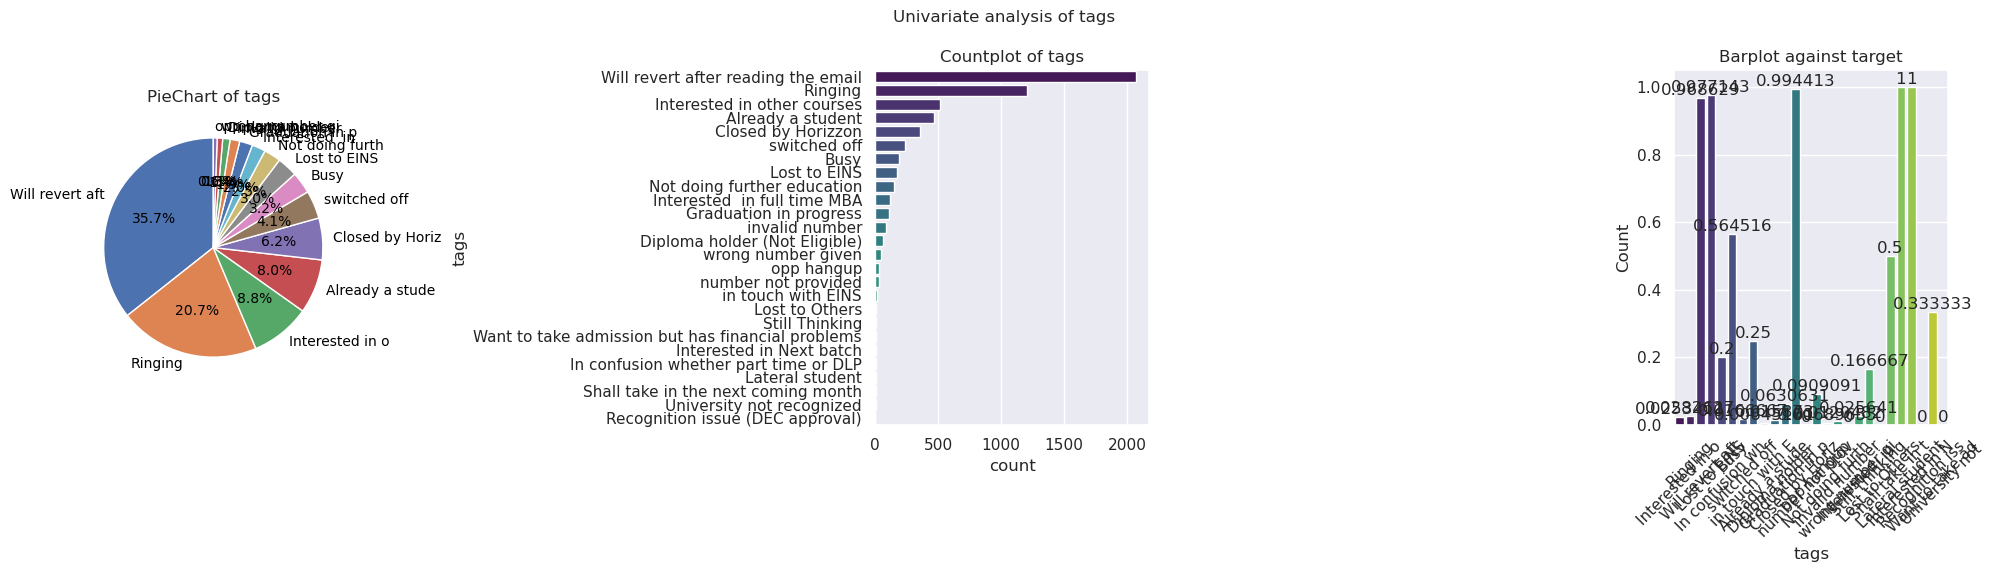

<Figure size 640x480 with 0 Axes>

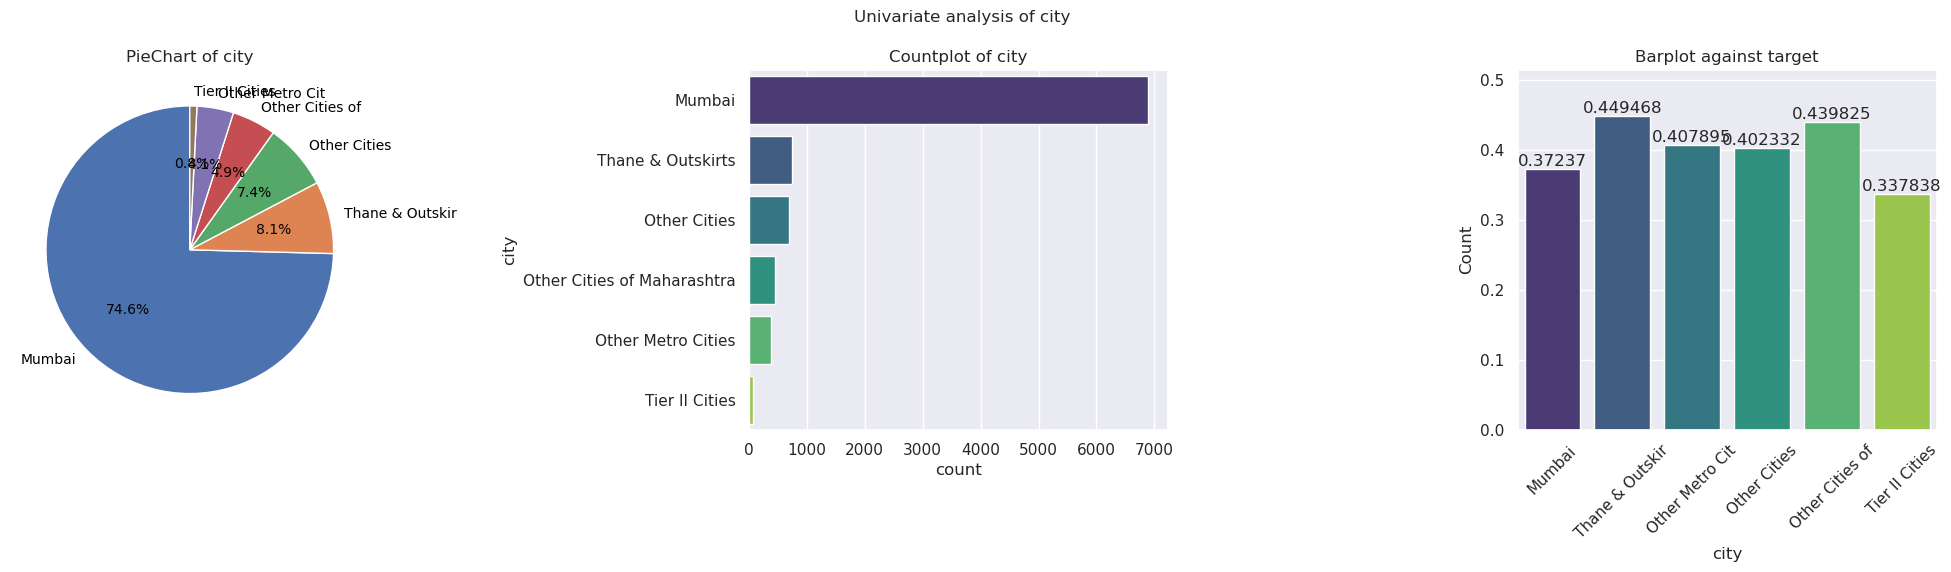

<Figure size 640x480 with 0 Axes>

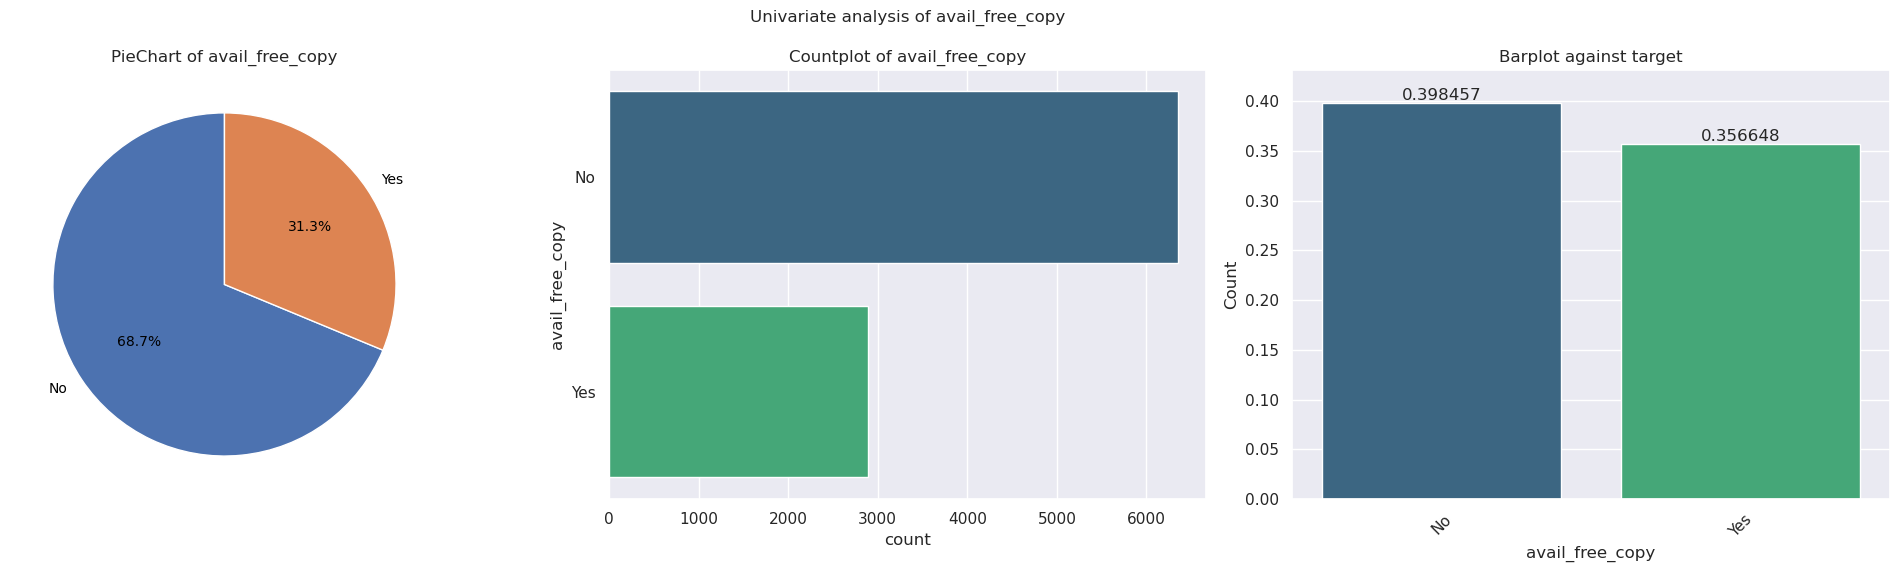

<Figure size 640x480 with 0 Axes>

In [755]:
# univariate plots
univariate_plots(lead_score_df, lead_score_df.select_dtypes(include=[int,float]).columns, ftype='non_categorical', target='converted')
univariate_plots(lead_score_df, lead_score_df.select_dtypes(exclude=[int,float]).columns, ftype='categorical', target='converted')

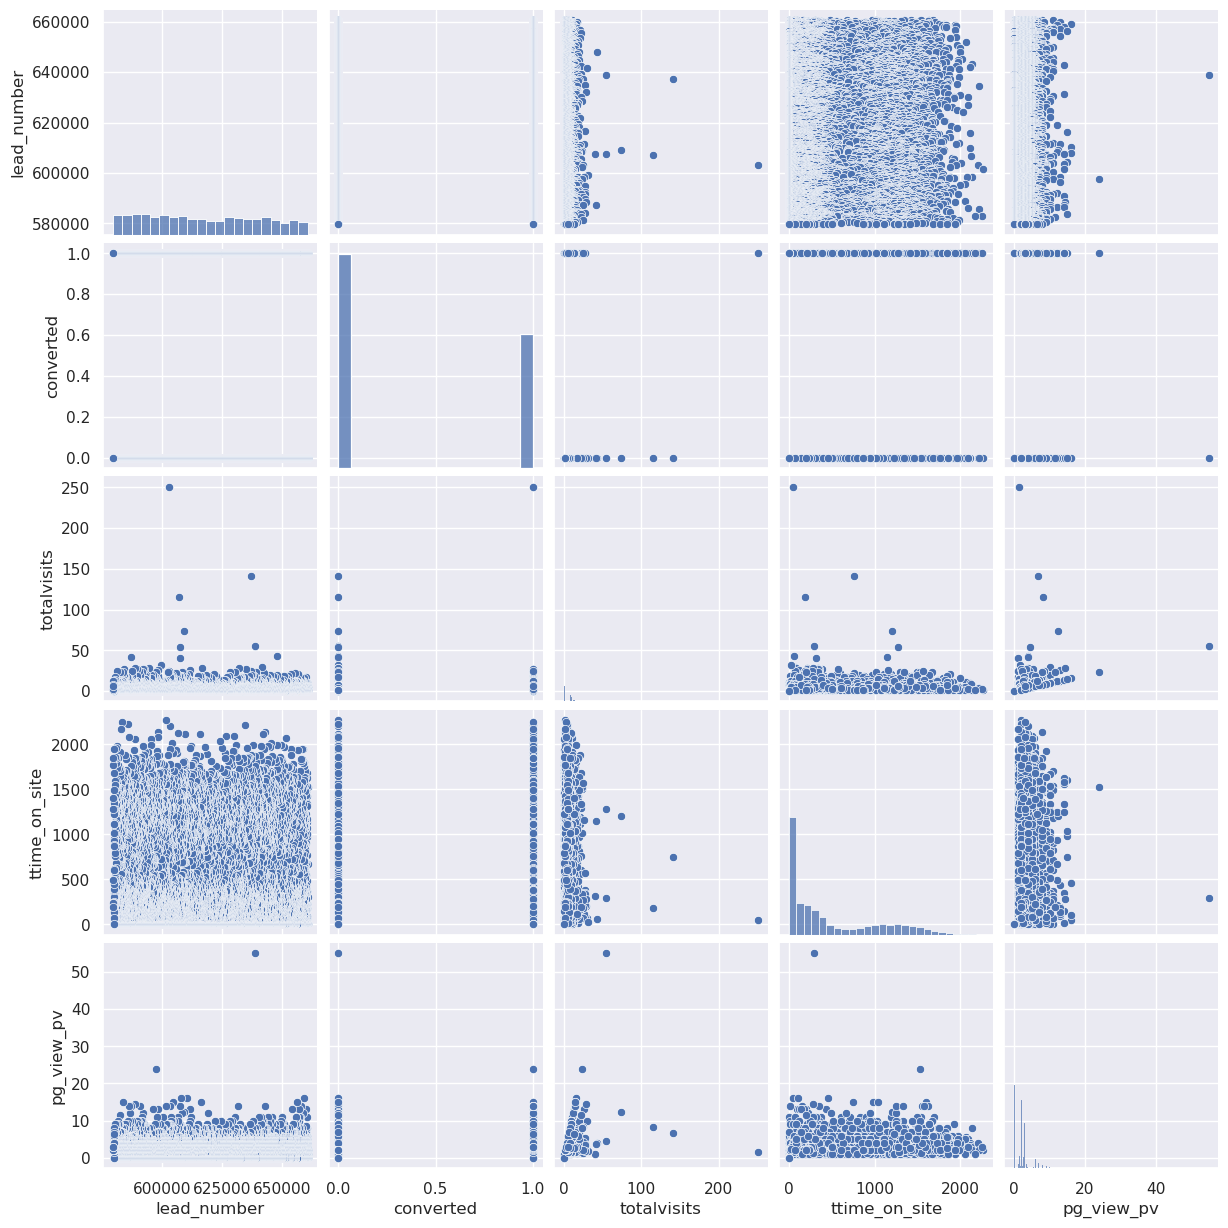

In [756]:
# bivariate plots
sns.pairplot(lead_score_df)

<Figure size 1000x600 with 0 Axes>

<Axes: >

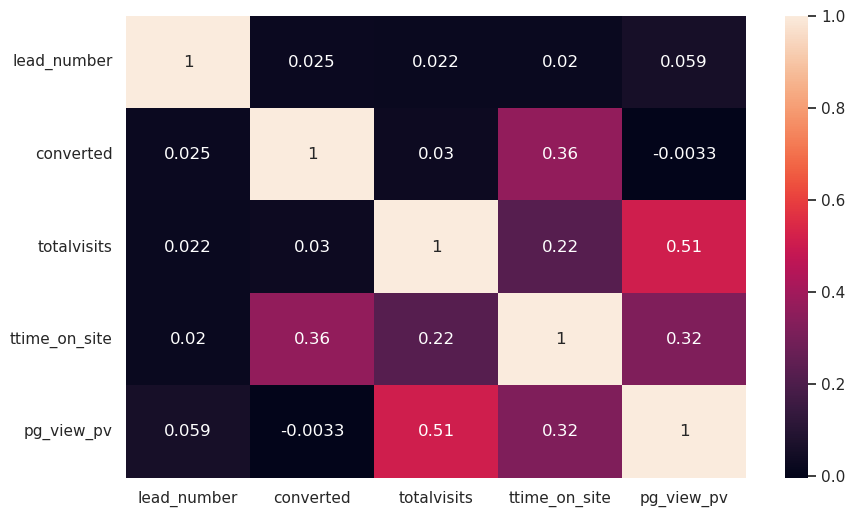

In [757]:
# multivariate plots
plt.figure(figsize = (10, 6)) # Size of the figure
sns.heatmap(lead_score_df.select_dtypes(exclude='category').corr(), annot = True)
plt.show()

####  ----------------------------------------------------------------------

#### Outlier Analysis and Capping

In [758]:
ex_val_df = get_extremeval_threshld(df=lead_score_df.select_dtypes(exclude=['category','object']) )
ex_val_df
lead_score_df.describe(percentiles=[.05,.1,.2,.5,.8,.9])

,thresh_low,thresh_high
name,,
lead_number,535130.375,698741.375
converted,-1.500,2.500
totalvisits,-5.000,11.000
ttime_on_site,-1374.000,2322.000
pg_view_pv,-2.000,6.000


,lead_number,converted,totalvisits,ttime_on_site,pg_view_pv
count,9240.000,9240.000,9103.000,9240.000,9103.000
mean,617188.436,0.385,3.445,487.698,2.363
std,23405.996,0.487,4.855,548.021,2.161
min,579533.000,0.000,0.000,0.000,0.000
5%,582869.900,0.000,0.000,0.000,0.000
10%,586361.700,0.000,0.000,0.000,0.000
20%,592772.800,0.000,0.000,0.000,0.000
50%,615479.000,0.000,3.000,248.000,2.000
80%,641577.600,1.000,5.000,1087.200,4.000
90%,650506.100,1.000,7.000,1380.000,5.000


In [759]:
# Fix Outliers by setting either thresh low or thresh low for both extremes 
lower_cutoff = ex_val_df.loc['pg_view_pv','thresh_low']
lead_score_df['pg_view_pv'] = np.where((lead_score_df['pg_view_pv'] < lower_cutoff), lower_cutoff, lead_score_df['pg_view_pv'])
upper_cutoff = ex_val_df.loc['pg_view_pv','thresh_high']
lead_score_df['pg_view_pv'] = np.where((lead_score_df['pg_view_pv'] > upper_cutoff), upper_cutoff, lead_score_df['pg_view_pv'])

# Fix Outliers by setting either thresh low or thresh low for both extremes
lower_cutoff = ex_val_df.loc['totalvisits','thresh_low']
lead_score_df['totalvisits'] = np.where((lead_score_df['totalvisits'] < lower_cutoff), lower_cutoff, lead_score_df['totalvisits'])
upper_cutoff = ex_val_df.loc['totalvisits','thresh_high']
lead_score_df['totalvisits'] = np.where((lead_score_df['totalvisits'] > upper_cutoff), upper_cutoff, lead_score_df['totalvisits'])

# Fix Outliers by setting either thresh low or thresh low for both extremes
lower_cutoff = ex_val_df.loc['ttime_on_site','thresh_low']
lead_score_df['ttime_on_site'] = np.where((lead_score_df['ttime_on_site'] < lower_cutoff), lower_cutoff, lead_score_df['ttime_on_site'])
upper_cutoff = ex_val_df.loc['ttime_on_site','thresh_high']
lead_score_df['ttime_on_site'] = np.where((lead_score_df['ttime_on_site'] > upper_cutoff), upper_cutoff, lead_score_df['ttime_on_site'])

In [760]:
lead_score_df.describe()

,lead_number,converted,totalvisits,ttime_on_site,pg_view_pv
count,9240.000,9240.000,9103.000,9240.000,9103.000
mean,617188.436,0.385,3.221,487.698,2.259
std,23405.996,0.487,2.882,548.021,1.793
min,579533.000,0.000,0.000,0.000,0.000
25%,596484.500,0.000,1.000,12.000,1.000
50%,615479.000,0.000,3.000,248.000,2.000
75%,637387.250,1.000,5.000,936.000,3.000
max,660737.000,1.000,11.000,2272.000,6.000


In [761]:
lead_score_df['totalvisits'] = lead_score_df['totalvisits'].replace(to_replace=np.nan, value=lead_score_df['totalvisits'].mean())
lead_score_df['pg_view_pv'] = lead_score_df['pg_view_pv'].replace(to_replace=np.nan, value=lead_score_df['pg_view_pv'].mean())

In [762]:
# replace Yes, No with 1 and 0
lead_score_df = lead_score_df.replace(to_replace=['Yes', 'No'], value=[1, 0])

####  ----------------------------------------------------------------------

#### Custom Code to be removed !!!!!!

In [763]:
# for label_encoding:
cols_to_le = [i for i in lead_score_df.columns if ((lead_score_df[i].dtype == 'category') and len(lead_score_df[i].unique()) > 5)]
cols_to_le

['lead_source',
 'last_activity',
 'country',
 'specialization',
 'curr_occupation',
 'tags',
 'city']

In [764]:
le = LabelEncoder()
df_le = lead_score_df[cols_to_le].apply(le.fit_transform)

<Figure size 1000x600 with 0 Axes>

<Axes: >

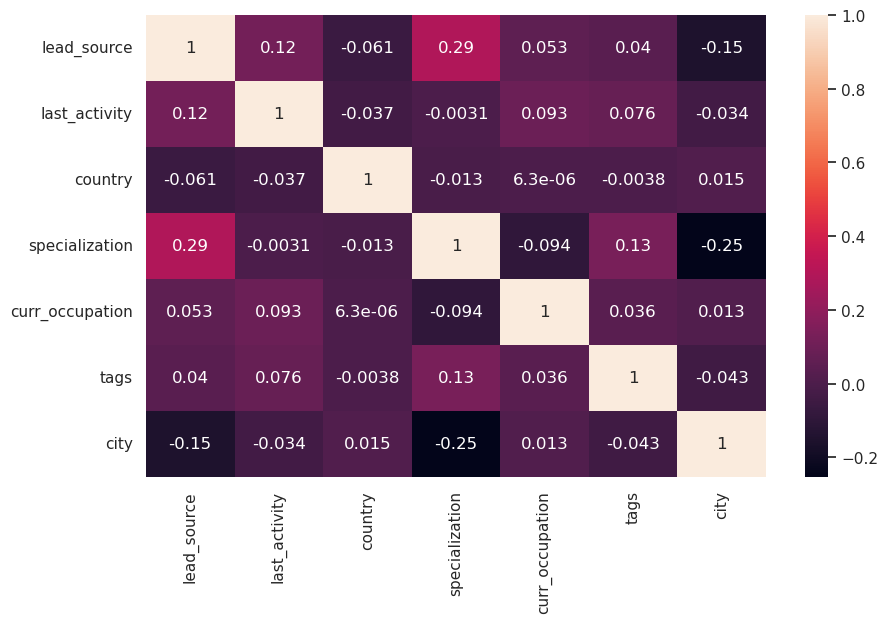

In [765]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_le.corr(), annot=True)

In [766]:
new_ls_df = lead_score_df[lead_score_df.columns.difference(cols_to_le)]
new_ls_df = new_ls_df.merge(right=df_le, right_index=True, left_index=True)
new_ls_df.head()

,avail_free_copy,converted,do_not_email,lead_number,lead_origin,pg_view_pv,reason_behind_course,totalvisits,ttime_on_site,lead_source,last_activity,country,specialization,curr_occupation,tags,city
0,0,0,0,660737,API,0.000,Better Career Prospects,0.000,0.000,6,10,12,18,4,8,0
1,0,0,0,660728,API,2.500,Better Career Prospects,5.000,674.000,7,5,12,18,4,14,0
2,1,1,0,660727,Landing Page Submission,2.000,Better Career Prospects,2.000,1532.000,1,5,12,1,3,19,0
3,0,0,0,660719,Landing Page Submission,1.000,Better Career Prospects,1.000,305.000,1,13,12,11,4,14,0
4,0,1,0,660681,Landing Page Submission,1.000,Better Career Prospects,2.000,1428.000,3,1,12,18,4,19,0


In [767]:
check_cols_null_pct(new_ls_df)
# new_ls_df = new_ls_df[(new_ls_df.notna()).all(axis=1)]
# check_cols_null_pct(new_ls_df)
# sorted([f'{i} - {new_ls_df[i].unique()}' for i in new_ls_df.columns])
new_ls_df.shape

avail_free_copy        0.000
converted              0.000
do_not_email           0.000
lead_number            0.000
lead_origin            0.000
pg_view_pv             0.000
reason_behind_course   0.000
totalvisits            0.000
ttime_on_site          0.000
lead_source            0.000
last_activity          0.000
country                0.000
specialization         0.000
curr_occupation        0.000
tags                   0.000
city                   0.000
dtype: float64

(9240, 16)

####  ----------------------------------------------------------------------

#### Dummy Encoding

In [768]:
# for label_encoding:
cols_to_de = [i for i in new_ls_df.columns if ((new_ls_df[i].dtype == 'category') and len(new_ls_df[i].unique()) <= 5)]
cols_to_de
new_ls_df = pd.get_dummies(new_ls_df, columns=cols_to_de, drop_first=True, dtype=float)

['avail_free_copy', 'do_not_email', 'lead_origin', 'reason_behind_course']

In [769]:
new_ls_df.head(1)

,converted,lead_number,pg_view_pv,totalvisits,ttime_on_site,lead_source,last_activity,country,specialization,curr_occupation,tags,city,avail_free_copy_1,do_not_email_1,lead_origin_Landing Page Submission,lead_origin_Lead Add Form,lead_origin_Lead Import,lead_origin_Quick Add Form,reason_behind_course_Flexibility & Convenience,reason_behind_course_Other
0,0,660737,0.000,0.000,0.000,6,10,12,18,4,8,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


####  ----------------------------------------------------------------------

#### Model Training

In [770]:
X = new_ls_df.drop(['converted'], axis=1)
y = new_ls_df['converted']

In [771]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)

In [772]:
# to_scale = ['lead_number', 'totalvisits', 'ttime_on_site', 'pg_view_pv']
to_scale = ['lead_number', 'totalvisits', 'ttime_on_site', 'pg_view_pv', 'lead_source', 'last_activity', 'country', 'specialization', 'curr_occupation', 'tags']
scaler = StandardScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale],y_train)
X_train.head()

,lead_number,pg_view_pv,totalvisits,ttime_on_site,lead_source,last_activity,country,specialization,curr_occupation,tags,city,avail_free_copy_1,do_not_email_1,lead_origin_Landing Page Submission,lead_origin_Lead Add Form,lead_origin_Lead Import,lead_origin_Quick Add Form,reason_behind_course_Flexibility & Convenience,reason_behind_course_Other
7263,-0.994,-1.272,-1.128,-0.885,0.529,-0.747,-0.137,1.062,-0.134,-1.869,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6468,-0.716,-0.146,-0.429,-0.632,-1.021,1.106,-0.137,-0.241,-0.134,0.380,0,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
7833,-1.169,-0.146,-0.429,-0.740,-1.021,1.106,-0.137,-1.871,-0.134,-1.987,1,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
4461,-0.010,0.980,0.269,2.007,-0.401,1.106,-0.137,-1.382,-0.134,-0.448,0,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
8453,-1.355,-1.272,-1.128,-0.885,0.529,0.312,-0.137,1.062,-0.134,0.972,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [773]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7372
Model Family:                Binomial   Df Model:                           19
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3414.3
Date:                Sat, 12 Oct 2024   Deviance:                       6828.7
Time:                        21:39:43   Pearson chi2:                 9.43e+03
No. Iterations:                    19   Pseudo R-squ. (CS):             0.3343
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -0.4324      0.060     -7.254      0.000      -0.549      -0.316
lead_number                                        0.0467      0.031      1.504      0.133      -0.014       0.107
pg_view_pv                                        -0.2918      0.049     -5.982      0.000      -0.387      -0.196
totalvisits                                        0.1651      0.043      3.799      0.000       0.080       0.250
ttime_on_site                                      1.0481      0.034     30.934      0.000       0.982       1.114
lead_source                                        0.1201      0.045      2.670      0.008       0.032       0.208
last_activity                                      0.4995      0.033     15.165      0.000       0.435       0.564
country                                            0.0154      0.030      0.514      0.608      -0.043       0.074
specialization                                    -0.3749      0.040     -9.364      0.000      -0.453      -0.296
curr_occupation                                    0.4574      0.037     12.305      0.000       0.385       0.530
tags                                               0.1124      0.032      3.474      0.001       0.049       0.176
city                                               0.0609      0.024      2.539      0.011       0.014       0.108
avail_free_copy_1                                 -0.1494      0.078     -1.928      0.054      -0.301       0.002
do_not_email_1                                    -1.4929      0.148    -10.070      0.000      -1.783      -1.202
lead_origin_Landing Page Submission               -0.4954      0.101     -4.909      0.000      -0.693      -0.298
lead_origin_Lead Add Form                          3.2998      0.200     16.481      0.000       2.907       3.692
lead_origin_Lead Import                           -0.8249      0.448     -1.840      0.066      -1.704       0.054
lead_origin_Quick Add Form                        18.5296   1.77e+04      0.001      0.999   -3.47e+04    3.48e+04
reason_behind_course_Flexibility & Convenience    -1.9899      4.300     -0.463      0.644     -10.418       6.438
reason_behind_course_Other                       -18.3885   1.77e+04     -0.001      0.999   -3.48e+04    3.47e+04
==================================================================================================================
"""

In [774]:
logreg = LogisticRegression()

rfe = RFE(estimator=logreg, n_features_to_select=15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('lead_number', False, 4),
 ('pg_view_pv', True, 1),
 ('totalvisits', True, 1),
 ('ttime_on_site', True, 1),
 ('lead_source', True, 1),
 ('last_activity', True, 1),
 ('country', False, 5),
 ('specialization', True, 1),
 ('curr_occupation', True, 1),
 ('tags', True, 1),
 ('city', False, 3),
 ('avail_free_copy_1', True, 1),
 ('do_not_email_1', True, 1),
 ('lead_origin_Landing Page Submission', True, 1),
 ('lead_origin_Lead Add Form', True, 1),
 ('lead_origin_Lead Import', True, 1),
 ('lead_origin_Quick Add Form', True, 1),
 ('reason_behind_course_Flexibility & Convenience', True, 1),
 ('reason_behind_course_Other', False, 2)]

In [775]:
col = X_train.columns[rfe.support_]
X_train.columns[~rfe.support_]

Index(['lead_number', 'country', 'city', 'reason_behind_course_Other'], dtype='object')

In [776]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7376
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3418.9
Date:                Sat, 12 Oct 2024   Deviance:                       6837.9
Time:                        21:39:44   Pearson chi2:                 9.53e+03
No. Iterations:                    19   Pseudo R-squ. (CS):             0.3335
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -0.4098      0.059     -6.952      0.000      -0.525      -0.294
pg_view_pv                                        -0.2828      0.048     -5.832      0.000      -0.378      -0.188
totalvisits                                        0.1657      0.043      3.812      0.000       0.080       0.251
ttime_on_site                                      1.0516      0.034     31.052      0.000       0.985       1.118
lead_source                                        0.1247      0.045      2.774      0.006       0.037       0.213
last_activity                                      0.4889      0.033     15.042      0.000       0.425       0.553
specialization                                    -0.3799      0.040     -9.516      0.000      -0.458      -0.302
curr_occupation                                    0.4594      0.037     12.356      0.000       0.387       0.532
tags                                               0.1155      0.032      3.579      0.000       0.052       0.179
avail_free_copy_1                                 -0.1430      0.077     -1.860      0.063      -0.294       0.008
do_not_email_1                                    -1.5026      0.148    -10.150      0.000      -1.793      -1.212
lead_origin_Landing Page Submission               -0.4640      0.100     -4.661      0.000      -0.659      -0.269
lead_origin_Lead Add Form                          3.3105      0.200     16.559      0.000       2.919       3.702
lead_origin_Lead Import                           -0.7038      0.444     -1.584      0.113      -1.575       0.167
lead_origin_Quick Add Form                        18.6714   1.77e+04      0.001      0.999   -3.47e+04    3.48e+04
reason_behind_course_Flexibility & Convenience    -1.8755      4.037     -0.465      0.642      -9.788       6.037
==================================================================================================================
"""

In [777]:
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

7263   0.105
6468   0.227
7833   0.270
4461   0.871
8453   0.214
7094   0.980
7932   0.168
449    0.880
5382   0.777
3768   0.214
dtype: float64

In [778]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.10453182, 0.22716634, 0.27043745, 0.87059121, 0.21379315,
       0.97989226, 0.16756807, 0.87970134, 0.77655592, 0.21379315])

In [779]:
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['CustID'] = y_train.index
y_train_pred_final.head()

,Churn,Churn_Prob,CustID
0,1,0.105,7263
1,0,0.227,6468
2,1,0.270,7833
3,0,0.871,4461
4,0,0.214,8453


In [780]:
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,Churn,Churn_Prob,CustID,predicted
0,1,0.105,7263,0
1,0,0.227,6468,0
2,1,0.270,7833,0
3,0,0.871,4461,1
4,0,0.214,8453,0


In [781]:
# Confusion matrix 
confusion = confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

[[4045  518]
 [ 975 1854]]


In [782]:
print(accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

0.7980248917748918


In [783]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
10,lead_origin_Landing Page Submission,2.740
0,pg_view_pv,2.640
1,totalvisits,2.380
3,lead_source,2.160
8,avail_free_copy_1,2.160
11,lead_origin_Lead Add Form,2.010
5,specialization,1.390
2,ttime_on_site,1.210
9,do_not_email_1,1.110
4,last_activity,1.070


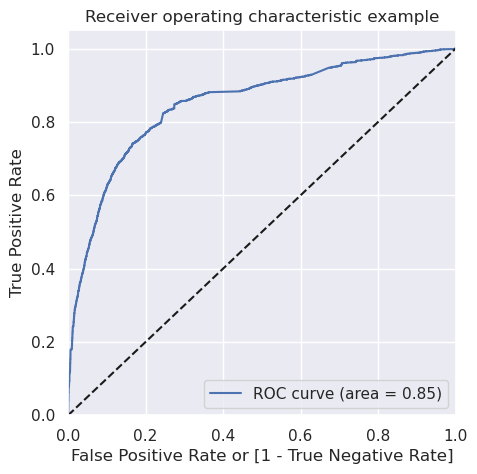

In [784]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs, drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    return None

fpr, tpr, thresholds = roc_curve( y_train_pred_final.Churn, y_train_pred_final.Churn_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

In [785]:
precision_score(y_train_pred_final.Churn, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Churn, y_train_pred_final.predicted)

0.781618887015177

0.6553552492046659

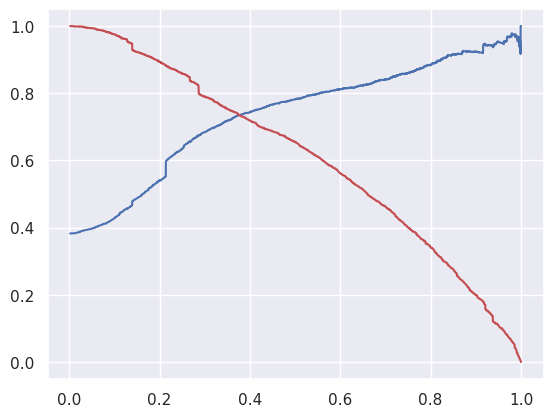

In [786]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)
plt.plot(thresholds, p[:-1], "b-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

####  ----------------------------------------------------------------------